# Prediction_Alkalis

## TO-DOs
```
[v] Import monthly electrcity data
[v] Import monthly TTF_GAS data
[v] Import price evaluatioin data
[v] Create rows and encoding Alkalis_RM02_0001, Alkalis_RM02_0002
[v] To calculate the monthly average prices of Alkalis
[v] Create 12*N features, external factor prices from one-month before to 12-month before
[v] Combine features with target variables
[v] train_test_split() - do calculation and scaling only based on train data set to prevent data leakage
[x] Detect outliers - skip
[v] Check data distribution
[v] Data scaling - log transformation
[x] check multicollinearity(to run one regression using each features, and find corr of all feature, filtering those with higher performance and least corr for our last model) - skip
[v] Lasso regression - fit and transform train data set
[v] Cross validation and Hyperparameter tuning using RandomizedSearchCV
[v] Lasso regression - transform test data set
[] Compare Lasso with Naive forecast
[] Visualisation
```

In [1]:
!pip install fredapi

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import preprocessor as pre
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.naive import NaiveForecaster
import seaborn as sns

In [3]:
def monthly_mean_to_daily(df_monthly: pd.core.frame.DataFrame ) -> pd.core.frame.DataFrame:
    """
    Convert Monthly data into Daily data and impute with monthly mean prices
    """
    df_monthly['Date'] = pd.to_datetime(df_monthly[['Year', 'Month']].assign(DAY=1))
    df = df_monthly.explode('Date') # The explode() method converts each element of the specified column(s) into a row.

    # Generate a complete range of daily dates for the year for imputation
    start_date = df['Date'].min() # represents the starting point of your data
    end_date = df['Date'].max() + pd.offsets.MonthEnd(1)  # finds the maximum (or latest) date and include the last month fully
    full_date_range = pd.date_range(start=start_date, end=end_date, freq='D') # generates a fixed-frequency DatetimeIndex

    # Merge the full date range with the monthly averages to fill in all days
    df_full_date_range = pd.DataFrame(full_date_range, columns=['Date'])
    df = pd.merge(df_full_date_range, df_monthly, on='Date', how='left')
    df_daily = df.ffill(axis=0) # to fill the missing value based on last valid observation following index sequence
    return df_daily

In [3]:
gas_df = pre.get_Fred_data('PNGASEUUSDM',2011,2023)
elec_df = pre.clean_elec_csv('ELECTRICITY_02_2024.csv',2011,2023)
price_evo_df = pre.clean_pred_price_evo_csv('Dataset_Future_Predicting_Price_Evolutions.csv',2012,2023)

dummy_df = pre.get_dummies_and_average_price(price_evo_df,'Alkalis',\
                                         'RM02/0001','RM02/0002')
# nan_counts = dummy_df.groupby(['Year', 'Month', 'RM01/0004', 'RM01/0006', 'RM01/0007'])['Average_price'].apply(lambda x: x.isna().sum())
# print(nan_counts)

Alkalis_df = pre.generate_features(1,12,dummy_df,Electricity=elec_df,PNGASEUUSDM=gas_df)

# print(Alkalis_df.info())

In [4]:
## train_test_split()
## Log transformation

# # Observe data distribution
# Alkalis_df_dummies.drop(['RM02/0002','Time', 'Group Description', 'Year','Month'],axis=1).hist()
# Alkalis_df_dummies['Average_price'].hist()

# Create X, y
feature_list = Alkalis_df.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X = feature_list.values
y = Alkalis_df['Average_price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 30% of our data as the test set

# Log transformation and standardlisation
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_log.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test_log.reshape(-1,1))

In [5]:
## Lasso regression - fit and transform train data set
## Cross validation and Hyperparameter tuning using RandomizedSearchCV

# Define the parameter grid
param_grid = {'alpha': np.linspace(0.0000001, 1, 3000)}

# Create a Lasso regression model
lasso = Lasso()

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=lasso, 
                                   param_distributions=param_grid, 
                                   n_iter=300, 
                                   cv=5, 
                                   random_state=42)

# Fit the data to perform a grid search
random_search.fit(X_train_scaled, y_train_scaled)

# Best alpha parameter
print("Best alpha parameter:", random_search.best_params_['alpha'])

# Best R-squared score
print("Best R-squared score:", round(random_search.best_score_, 3))

# Coefficients of the best Lasso model
assert random_search.n_features_in_ == len(feature_list.columns)
print("Coefficients of the selected features in the best Lasso model:")
for feature, coefficient in zip(feature_list.columns, random_search.best_estimator_.coef_):
    print(f"{feature}: {round(coefficient,3)}")

Best alpha parameter: 1e-07
Best R-squared score: 0.924
Coefficients of the selected features in the best Lasso model:
RM02/0002: 0.467
Electricity_1: 0.351
PNGASEUUSDM_1: -0.028
Electricity_2: 0.291
PNGASEUUSDM_2: 0.329
Electricity_3: -0.152
PNGASEUUSDM_3: -0.309
Electricity_4: 0.059
PNGASEUUSDM_4: 0.202
Electricity_5: 0.131
PNGASEUUSDM_5: -0.081
Electricity_6: 0.158
PNGASEUUSDM_6: -0.003
Electricity_7: -0.041
PNGASEUUSDM_7: -0.098
Electricity_8: -0.041
PNGASEUUSDM_8: 0.168
Electricity_9: 0.017
PNGASEUUSDM_9: -0.056
Electricity_10: 0.38
PNGASEUUSDM_10: 0.045
Electricity_11: 0.127
PNGASEUUSDM_11: -0.084
Electricity_12: -0.151
PNGASEUUSDM_12: -0.219


In [6]:
## Lasso regression - transform test data set with reduced data granularity
# Get the best Lasso model from RandomizedSearchCV
best_lasso_model = random_search.best_estimator_

# Predict on the test data
y_pred_test = best_lasso_model.predict(X_test_scaled)

# Evaluate the model performance on the test data
test_score = best_lasso_model.score(X_test_scaled, y_test_scaled)
print("Best Model:", best_lasso_model)
print("Test Set R-squared score:", round(test_score, 3))

Best Model: Lasso(alpha=1e-07)
Test Set R-squared score: 0.917


MAPE: 0.119


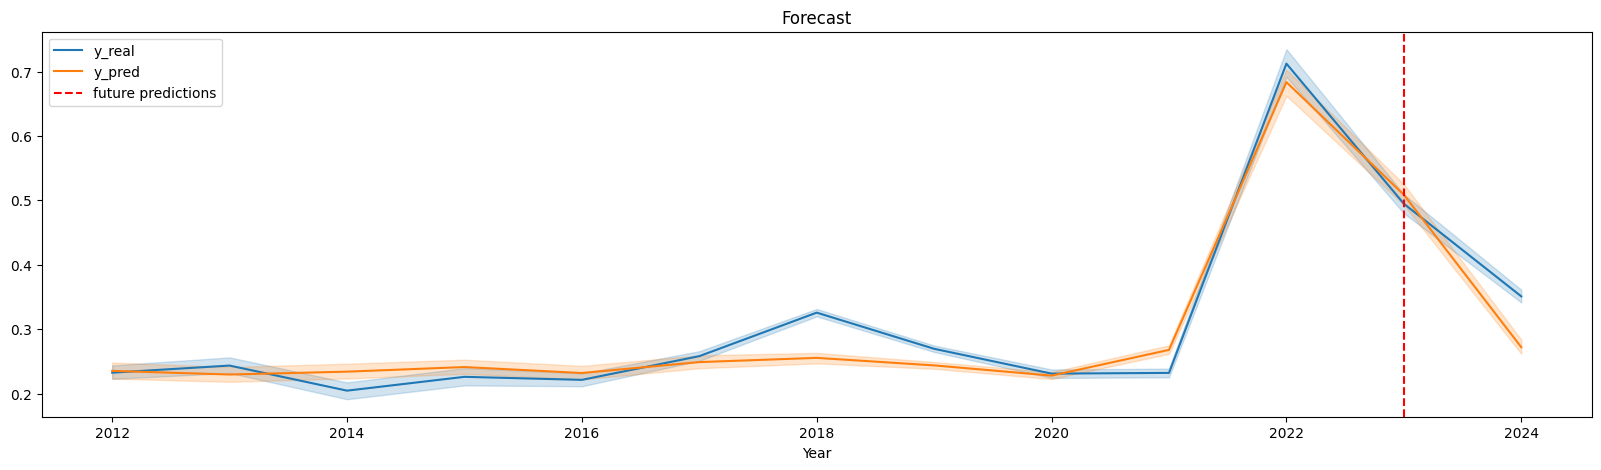

In [28]:
## Apply the trained model on the whole data set
gas_df = pre.get_Fred_data('PNGASEUUSDM',2011,2024)
elec_df = pre.clean_elec_csv('ELECTRICITY_02_2024.csv',2011,2024)
price_evo_df = pre.clean_pred_price_evo_csv('Dataset_Future_Predicting_Price_Evolutions.csv',2012,2024)
dummy_df = pre.get_dummies_and_average_price(price_evo_df,'Alkalis',\
                                         'RM02/0001','RM02/0002')
dummy_df_filtered = dummy_df[dummy_df['Time'] < '2024-03-01']
Alkalis_df_24 = pre.generate_features(1,12,dummy_df_filtered,Electricity=elec_df,PNGASEUUSDM=gas_df)
# Create X, y
feature_list = Alkalis_df_24.drop(['Time', 'Group Description', 'Year','Month','Average_price'],axis=1)
X_24 = feature_list.values
y_24 = Alkalis_df_24['Average_price'].values

# Log transformation and standardlisation
X_scaled_24 = scaler_x.transform(X_24)

y_pred_24 = best_lasso_model.predict(X_scaled_24)
y_pred_24_inverse = np.exp(scaler_y.inverse_transform(y_pred_24.reshape(-1,1))).reshape(-1)

mape_24 = mean_absolute_percentage_error(y_24,y_pred_24_inverse)
print(f'MAPE: {mape_24:.3f}')

# Visualisation for all Key RM codes
fig, ax = plt.subplots(figsize=[20,5])
sns.lineplot(data=Alkalis_df_24, x='Year', y='Average_price', label='y_real', ax=ax)
sns.lineplot(data=Alkalis_df_24, x='Year', y=y_pred_24_inverse, label='y_pred', ax=ax)
ax.axvline(x=2023, color='red', linestyle='--', label='future predictions')
ax.legend(loc='upper left')
ax.set(title='Forecast', ylabel='');

MAPE: 0.123


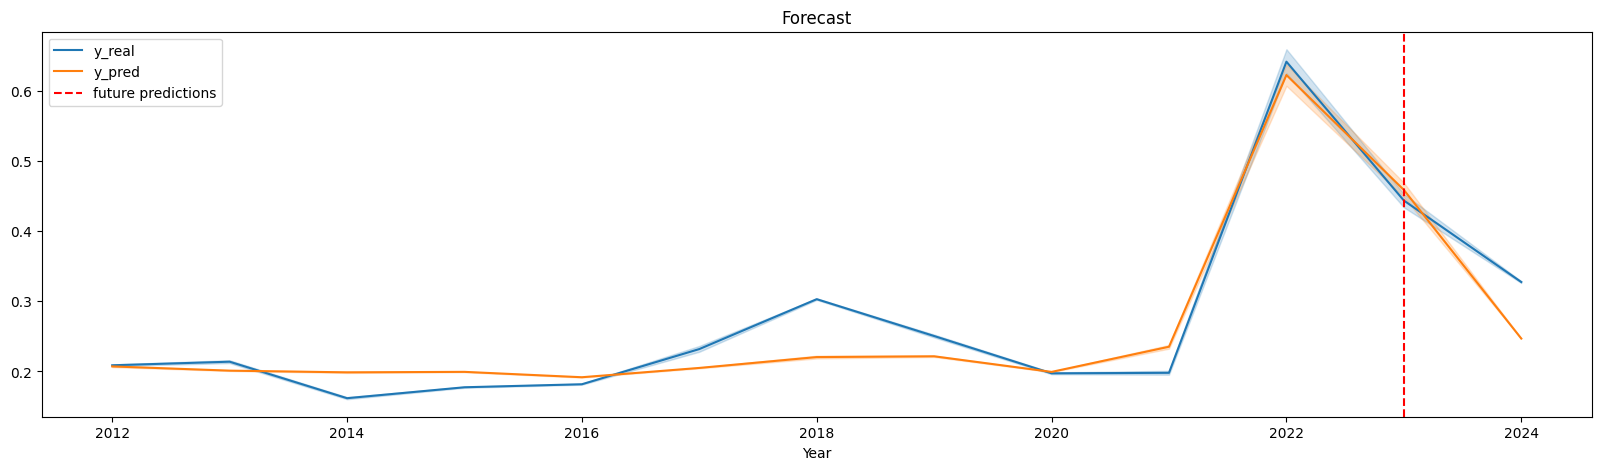

In [31]:
# Visualisation for RM02/0001
X_24_01 = feature_list[feature_list['RM02/0002'] == 0].values
y_24_01 = Alkalis_df_24[Alkalis_df_24['RM02/0002'] == 0]['Average_price'].values

X_scaled_24_01 = scaler_x.transform(X_24_01)

y_pred_24_01 = best_lasso_model.predict(X_scaled_24_01)
y_pred_24_inverse_01 = np.exp(scaler_y.inverse_transform(y_pred_24_01.reshape(-1,1))).reshape(-1)

mape_24_01 = mean_absolute_percentage_error(y_24_01,y_pred_24_inverse_01)
print(f'MAPE: {mape_24_01:.3f}')

# Visualisation for all Key RM codes
filter = (Alkalis_df_24['RM02/0002'] == 0)
fig, ax = plt.subplots(figsize=[20,5])
sns.lineplot(data=Alkalis_df_24[filter], x='Year', y='Average_price', label='y_real', ax=ax)
sns.lineplot(data=Alkalis_df_24[filter], x='Year', y=y_pred_24_inverse_01, label='y_pred', ax=ax)
ax.axvline(x=2023, color='red', linestyle='--', label='future predictions')
ax.legend(loc='upper left')
ax.set(title='Forecast', ylabel='');

MAPE: 0.093


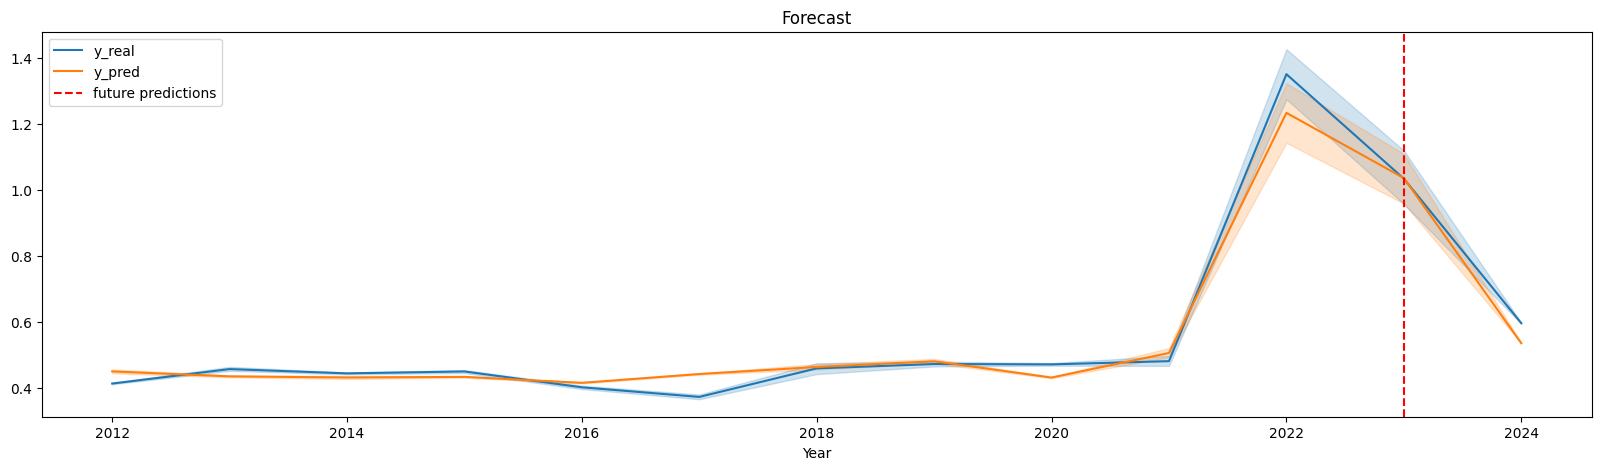

In [32]:
# Visualisation for RM02/0002
X_24_02 = feature_list[feature_list['RM02/0002'] == 1].values
y_24_02 = Alkalis_df_24[Alkalis_df_24['RM02/0002'] == 1]['Average_price'].values

X_scaled_24_02 = scaler_x.transform(X_24_02)

y_pred_24_02 = best_lasso_model.predict(X_scaled_24_02)
y_pred_24_inverse_02 = np.exp(scaler_y.inverse_transform(y_pred_24_02.reshape(-1,1))).reshape(-1)

mape_24_02 = mean_absolute_percentage_error(y_24_02,y_pred_24_inverse_02)
print(f'MAPE: {mape_24_02:.3f}')

# Visualisation for all Key RM codes
filter = (Alkalis_df_24['RM02/0002'] == 1)
fig, ax = plt.subplots(figsize=[20,5])
sns.lineplot(data=Alkalis_df_24[filter], x='Year', y='Average_price', label='y_real', ax=ax)
sns.lineplot(data=Alkalis_df_24[filter], x='Year', y=y_pred_24_inverse_02, label='y_pred', ax=ax)
ax.axvline(x=2023, color='red', linestyle='--', label='future predictions')
ax.legend(loc='upper left')
ax.set(title='Forecast', ylabel='');